In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, boxcox, pearsonr, ks_2samp

# from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, HuberRegressor, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

import lightgbm as lgb
import xgboost as xgb

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from Dataset import RegionalDatasets, dataset

from ModelOptimizer import (
    lgbm_optimizer, 
    xgb_optimizer, 
    rf_optimizer, 
    svr_optimizer, 
    ridge_optimizer, 
    huber_optimizer,
    knn_optimizer,
    lasso_optimizer,
    elasticnet_optimizer,
    model_box
)

from MetaModel import RegionalBasedPredictors, StackingPredictor, BasicPredictors

In [2]:
def metric_train(output, truth):
    return spearmanr(output, truth).correlation

def my_metric(output, data):
    return "spearman", spearmanr(output, data.get_label()).correlation, True

In [3]:
X_train = pd.read_csv("data/raw/X_train_NHkHMNU.csv").set_index("ID")
y_train = pd.read_csv("data/raw/y_train_ZAN5mwg.csv").set_index("ID")
X_test = pd.read_csv("data/raw/X_test_final.csv").set_index("ID")
X_train.shape, y_train.shape, X_test.shape

((1494, 34), (1494, 1), (654, 34))

In [4]:
X_train.describe().loc[["mean", "std"]].T

,mean,std
DAY_ID,591.861446,345.065043
DE_CONSUMPTION,0.427442,0.673412
FR_CONSUMPTION,-0.020032,0.918995
DE_FR_EXCHANGE,-0.145508,0.970226
FR_DE_EXCHANGE,0.145508,0.970226
DE_NET_EXPORT,-0.256332,0.957443
FR_NET_EXPORT,-0.072643,1.075830
DE_NET_IMPORT,0.256332,0.957443
FR_NET_IMPORT,0.072643,1.075830
DE_GAS,0.780699,0.850190


In [5]:
X_test.describe().loc[["max", "min", "mean"]].T

,max,min,mean
DAY_ID,1214.000000,4.000000,632.744648
DE_CONSUMPTION,1.851717,-7.433311,0.435242
FR_CONSUMPTION,2.817944,-4.591011,0.034431
DE_FR_EXCHANGE,2.437265,-2.226614,-0.044960
FR_DE_EXCHANGE,2.226614,-2.437265,0.044960
DE_NET_EXPORT,2.104596,-2.413888,-0.221057
FR_NET_EXPORT,1.935559,-2.532384,-0.124737
DE_NET_IMPORT,2.413888,-2.104596,0.221057
FR_NET_IMPORT,2.532384,-1.935559,0.124737
DE_GAS,3.292225,-1.498254,0.822771


In [6]:
set(X_train.DAY_ID).intersection(set(X_test.DAY_ID))

set()

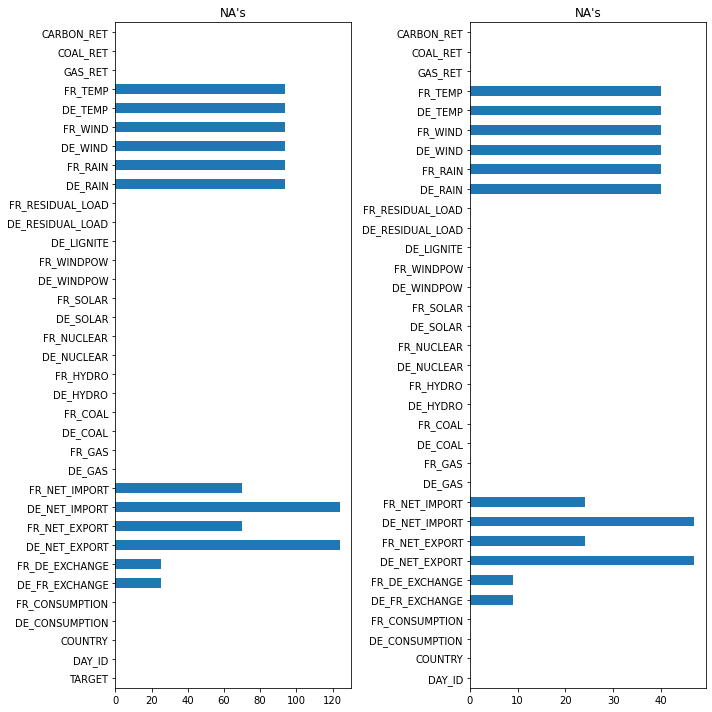

In [7]:
full_train = y_train.join(X_train)
full_train = full_train.replace("FR", 0)
full_train = full_train.replace("DE", 1)

X_test = X_test.replace("FR", 0)
X_test = X_test.replace("DE", 1)

fig, axs = plt.subplots(1,2,figsize=(10,10))
full_train.isna().sum(axis=0).plot(kind="barh", title="NA's", ax=axs[0])
X_test.isna().sum(axis=0).plot(kind="barh", title="NA's", ax=axs[1])
plt.tight_layout()

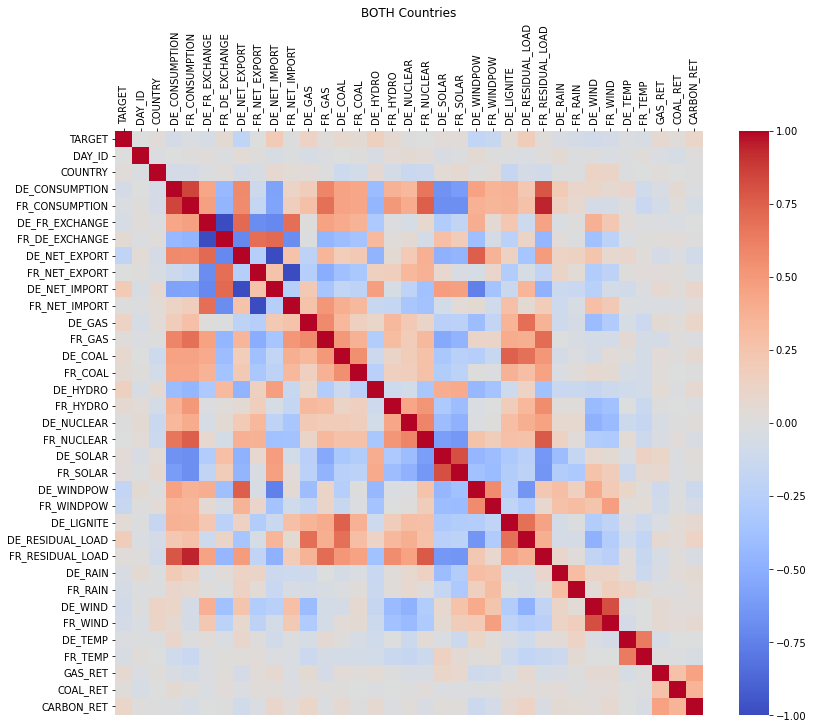

In [8]:
corr_train = full_train.corr(method="spearman")
plt.figure(figsize=(12,10))
ax = sns.heatmap(corr_train, cmap='coolwarm')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("BOTH Countries")
plt.show()

In [9]:
weather = ["FR_TEMP", "DE_TEMP", "FR_WIND", "DE_WIND", "FR_RAIN", "DE_RAIN"]
full_train[weather] = full_train[weather].fillna(full_train[weather].mean())
X_test[weather] = X_test[weather].fillna(full_train[weather].mean())

related_cols = corr_train.columns.to_list()[4:-5]
imputer = KNNImputer(n_neighbors=5)
imputer.fit(full_train[related_cols])
full_train[related_cols] = imputer.transform(full_train[related_cols])
X_test[related_cols] = imputer.transform(X_test[related_cols])

In [10]:
# fe1_full = pd.concat([full_train, X_test]).apply(lambda x: x.rank()/len(x) if x.name not in ["TARGET", "DAY_ID", "COUNTRY"] else x)
fe1_full = pd.concat([full_train, X_test])

In [11]:
fe1_train = fe1_full.loc[full_train.index].sort_values("DAY_ID")
fe1_train['RANK'] = fe1_train.TARGET.rank()
# fe1_train['RANK'] = fe1_train.TARGET.rank() / len(fe1_train)

X_test = fe1_full.loc[X_test.index].drop("TARGET", axis=1)

In [12]:
day_count = fe1_train.groupby("DAY_ID")["RANK"].count()
idxs_1 = day_count[day_count == 1].index.to_list()
idxs_2 = day_count[day_count == 2].index.to_list()

df_same_day = fe1_train.loc[fe1_train["DAY_ID"].isin(idxs_2)]
df_same_day.head(4)

,TARGET,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,RANK
ID,,,,,,,,,,,,,,,,,,,,,
1327,2.575976,2,0,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.14092,0.900434,1451.0
111,0.861270,2,1,-0.068972,-0.667390,-1.102015,1.102015,-1.080403,0.256736,1.080403,...,-0.344600,-0.372156,-0.623041,-0.926064,-0.148950,0.641235,1.802550,1.14092,0.900434,1343.0
2016,0.068905,3,0,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.06455,-0.032756,895.0
800,7.138604,3,1,-0.134670,-0.834564,-1.051716,1.051716,-1.881881,-0.612133,1.881881,...,-1.394561,-1.118297,0.244859,0.488650,-1.710888,-0.951057,0.440121,-0.06455,-0.032756,1493.0


In [13]:
df_single_day = fe1_train.loc[fe1_train["DAY_ID"].isin(idxs_1)]
df_single_day.head(4)

,TARGET,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,RANK
ID,,,,,,,,,,,,,,,,,,,,,
1057,0.108953,0,0,0.048418,-0.465067,-0.079296,0.079296,-0.222254,0.650577,0.222254,...,-0.987968,-0.856204,-0.655528,-1.099226,0.279885,0.583874,-1.071996,-0.074767,0.798003,960.0
1179,-0.063369,1,0,0.966997,1.222131,0.331356,-0.331356,0.405549,0.778627,-0.405549,...,-0.370990,-0.497520,-1.184018,-1.465608,1.349212,0.231602,1.480313,0.931562,0.822047,611.0
1106,-0.123739,15,0,0.225040,-0.380781,0.342203,-0.342203,0.968306,0.234530,-0.968306,...,-0.693404,-0.850386,-0.915662,-1.069080,-0.639265,-0.047712,0.605670,0.234493,0.840556,508.0
1170,-1.854479,18,0,1.254269,2.267644,1.677301,-1.677301,1.450056,-0.346182,-1.450056,...,-0.690319,-0.551568,-0.666652,-1.007217,-0.260168,-1.327920,-1.196786,1.367880,0.122051,34.0


In [14]:
day_count = X_test.groupby("DAY_ID")["COUNTRY"].count()
idxs_1 = day_count[day_count == 1].index.to_list()
idxs_2 = day_count[day_count == 2].index.to_list()
test_single_day = X_test.loc[X_test.DAY_ID.isin(idxs_1)]
test_same_day = X_test.loc[X_test.DAY_ID.isin(idxs_2)]

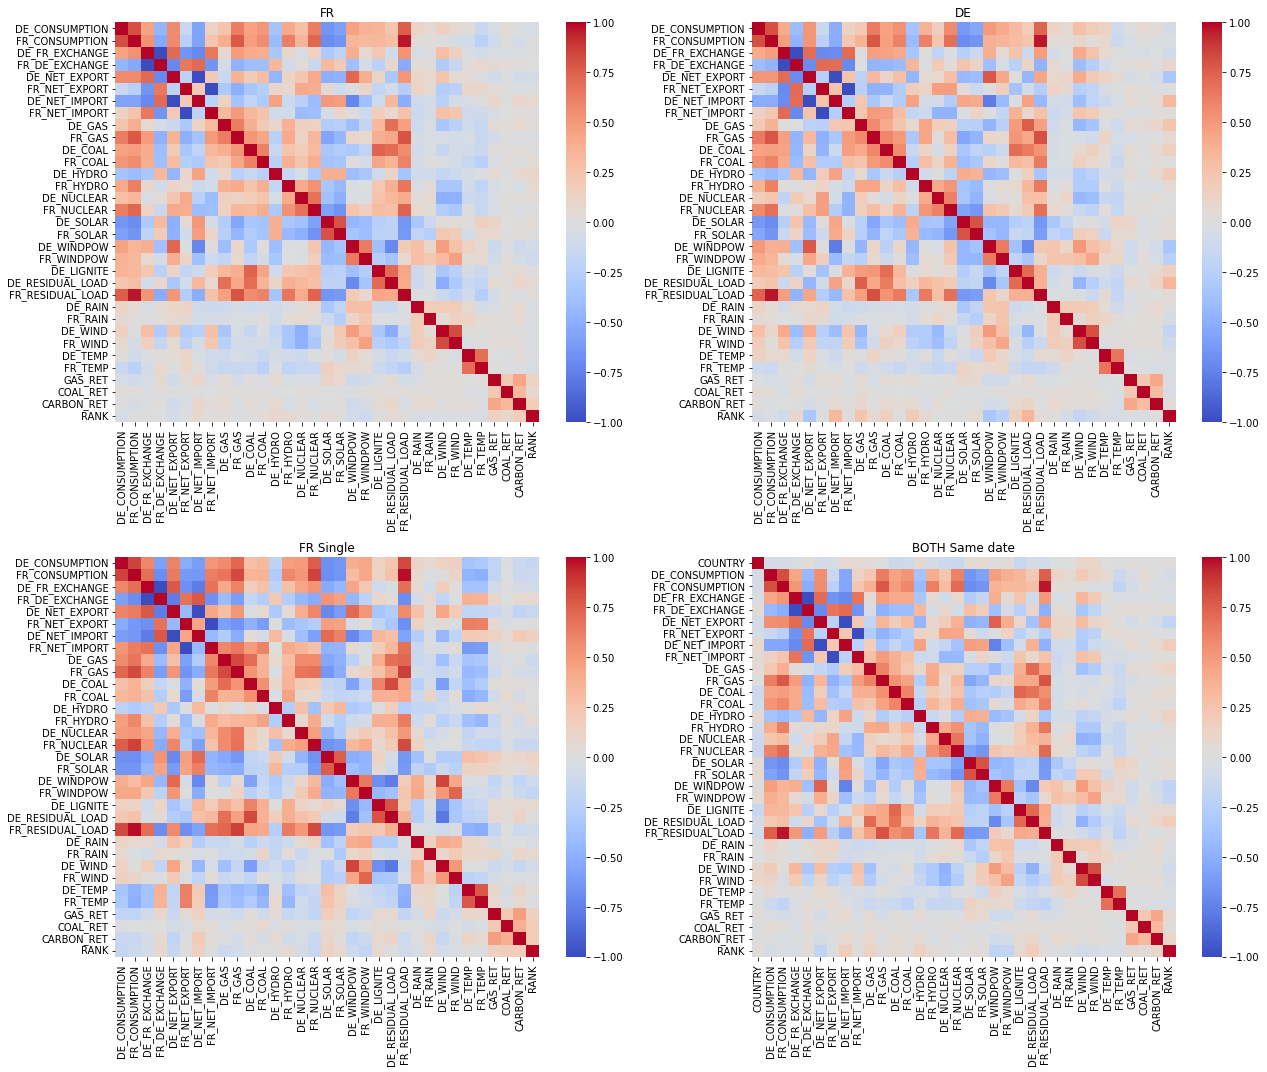

In [15]:
# fr_corr = fe1_train.loc[fe1_train.COUNTRY == 0].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
# de_corr = fe1_train.loc[fe1_train.COUNTRY == 1].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
# both_corr = fe1_train.drop(["DAY_ID", "TARGET"], axis=1).corr(method="pearson")

# fr_corr = df_same_day.loc[df_same_day.COUNTRY == 0].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
# de_corr = df_same_day.loc[df_same_day.COUNTRY == 1].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
# both_same_corr = df_same_day.drop(["DAY_ID", "TARGET"], axis=1).corr(method="pearson")

fr_corr = fe1_train.loc[fe1_train.COUNTRY == 0].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
de_corr = fe1_train.loc[fe1_train.COUNTRY == 1].drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")
both_same_corr = fe1_train.drop(["DAY_ID", "TARGET"], axis=1).corr(method="pearson")

fr_tmp = df_single_day.drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1)
fr_single_corr = df_single_day.drop(["COUNTRY", "DAY_ID", "TARGET"], axis=1).corr(method="pearson")

fig, axs = plt.subplots(2, 2, figsize=(18,15))
sns.heatmap(fr_corr, cmap='coolwarm', ax=axs[0][0])
axs[0][0].set_title("FR")
sns.heatmap(de_corr, cmap='coolwarm', ax=axs[0][1])
axs[0][1].set_title("DE")
sns.heatmap(fr_single_corr, cmap='coolwarm', ax=axs[1][0])
axs[1][0].set_title("FR Single")
sns.heatmap(both_same_corr, cmap='coolwarm', ax=axs[1][1])
axs[1][1].set_title("BOTH Same date")
fig.tight_layout()
plt.show()

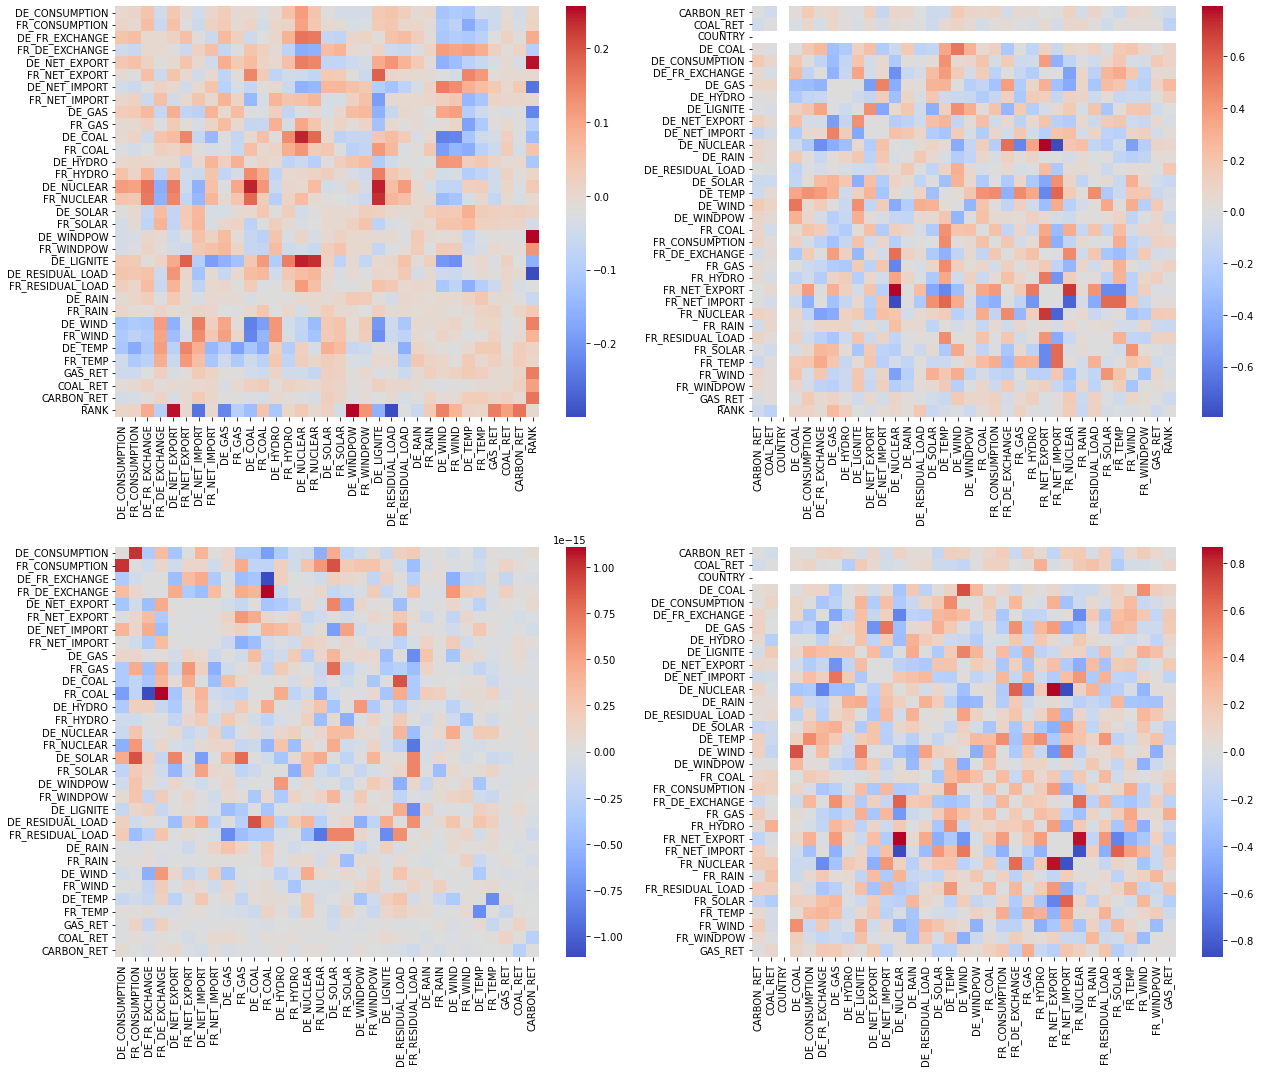

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(18,15))
test_fr_corr = test_same_day.loc[test_same_day.COUNTRY == 0].drop(["COUNTRY", "DAY_ID"], axis=1).corr()
test_de_corr = test_same_day.loc[test_same_day.COUNTRY == 1].drop(["COUNTRY", "DAY_ID"], axis=1).corr()
test_fr_single_corr = test_single_day.drop(["COUNTRY", "DAY_ID"], axis=1).corr()
test_both_same_corr = test_same_day.drop(["DAY_ID"], axis=1).corr()

sns.heatmap(fr_corr - de_corr, cmap='coolwarm', ax=axs[0][0])
sns.heatmap(both_same_corr - fr_single_corr, cmap='coolwarm', ax=axs[0][1])
sns.heatmap(test_fr_corr - test_de_corr, cmap='coolwarm', ax=axs[1][0])
sns.heatmap(test_both_same_corr - test_fr_single_corr, cmap='coolwarm', ax=axs[1][1])
fig.tight_layout()
plt.show()

In [19]:
class feat_selector():
    def __init__(self, corr):
        self.corr = corr
    def multi_colinear_feat(self, thres=0.8):
        dependency = {}
        losers = set()
        
        multi = self.corr[(self.corr.abs() > thres)]
        multi = multi.stack().index.to_list()
        for pair in multi:
            if pair[0] != pair[1]:
                pairs_tmp = self.corr.loc["RANK", [pair[0], pair[1]]].abs()
                if pairs_tmp.iloc[0] != pairs_tmp.iloc[1]:
                    winner = pairs_tmp.idxmax()
                    loser = pairs_tmp.idxmin()
                else: 
                    winner = sorted(pairs_tmp.index)[0]
                    loser = sorted(pairs_tmp.index)[1]

                losers.add(loser)
                if dependency.get(winner):
                    if loser not in dependency[winner]:
                        dependency[winner].append(loser)
                else:
                    dependency[winner] = [loser]
        return dependency, set(losers)

    def weak_feat(self, thres=0.05):
        weak = self.corr[(self.corr.abs() < thres)]
        weak = weak.index[~weak["RANK"].isna()].to_list()
        return set(weak)

    def l1_weak_feat(self, X, y, alpha=1e-3, thres=0.01):
        lasso = Lasso(alpha=alpha)
        lasso.fit(X, y)
        return (
            {X.columns[i]: lasso.coef_[i] for i in range(len(X.columns))}, 
            set(X.columns[i] for i in range(len(X.columns)) if abs(lasso.coef_[i]) < thres)
            )

fs = feat_selector(fr_single_corr)
_, fr_single_losers = fs.multi_colinear_feat(thres=0.7)
fr_single_weak = fs.weak_feat()
fr_single_coef, fr_single_l1_weak = fs.l1_weak_feat(
    df_single_day.drop(["COUNTRY", "DAY_ID", "TARGET", "RANK"], axis=1), 
    df_single_day["RANK"]
)

fs = feat_selector(de_corr)
_, de_losers = fs.multi_colinear_feat(thres=0.7)
de_weak = fs.weak_feat()
de_coef, de_l1_weak = fs.l1_weak_feat(
    fe1_train.loc[fe1_train.COUNTRY == 1].drop(["COUNTRY", "DAY_ID", "TARGET", "RANK"], axis=1), 
    fe1_train.loc[fe1_train.COUNTRY == 1]["RANK"]
)

fs = feat_selector(fr_corr)
_, fr_same_losers = fs.multi_colinear_feat(thres=0.7)
fr_same_weak = fs.weak_feat()
fr_same_coef, fr_same_l1_weak = fs.l1_weak_feat(
    fe1_train.loc[fe1_train.COUNTRY == 0].drop(["COUNTRY", "DAY_ID", "TARGET", "RANK"], axis=1), 
    fe1_train.loc[fe1_train.COUNTRY == 0]["RANK"]
)

fs = feat_selector(both_same_corr)
_, both_losers = fs.multi_colinear_feat(thres=0.7)
both_weak = fs.weak_feat()
both_coef, both_l1_weak = fs.l1_weak_feat(
    fe1_train.drop(["COUNTRY", "DAY_ID", "TARGET", "RANK"], axis=1), 
    fe1_train["RANK"]
)

dict_keys(['DE_CONSUMPTION', 'FR_CONSUMPTION', 'FR_NUCLEAR', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_RESIDUAL_LOAD', 'DE_COAL', 'DE_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_WIND', 'DE_TEMP'])


/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.164e+07, tolerance: 2.910e+03
  model = cd_fast.enet_coordinate_descent(
/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e+07, tolerance: 1.434e+04
  model = cd_fast.enet_coordinate_descent(
/Users/chantom/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

In [92]:
drop_fr_single = fr_single_losers
drop_de_same = de_losers
drop_fr_same = fr_same_losers
drop_both_same = both_losers

# drop_fr_single = fr_single_losers.union(fr_single_weak).union(fr_single_l1_weak)
# drop_de_same = de_losers.union(de_weak).union(de_l1_weak)
# drop_fr_same = fr_same_losers.union(fr_same_weak).union(fr_same_l1_weak)
# drop_both_same = both_losers.union(both_weak).union(both_l1_weak)

drop_cols_single = list(drop_fr_single)
drop_cols_same = list(drop_de_same)

KstestResult(statistic=0.1354348465715022, pvalue=2.5096221059062174e-06)
fr and de are statistically significant that they are two different distributions


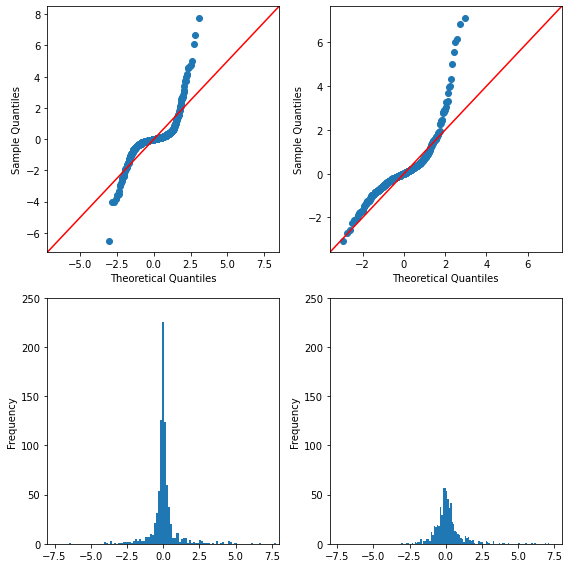

In [93]:
fr_target = full_train.loc[full_train.COUNTRY==0,"TARGET"]
de_target = full_train.loc[full_train.COUNTRY==1,"TARGET"]
fr_target_same = df_same_day.loc[df_same_day.COUNTRY==0,"TARGET"]
de_target_same = df_same_day.loc[df_same_day.COUNTRY==1,"TARGET"]
fr_target_single = df_single_day["TARGET"]

print(ks_2samp(fr_target, de_target))
print('fr and de are statistically significant that they are two different distributions')

fig, axs = plt.subplots(2,2,figsize=(8,8))
sm.qqplot(fr_target, line='45', ax=axs[0][0])
sm.qqplot(de_target, line='45', ax=axs[0][1])

fr_target.plot.hist(bins=100, ax=axs[1][0])
axs[1][0].set_xlim(-8, 8)
axs[1][0].set_ylim(0, 250)
de_target.plot.hist(bins=100, ax=axs[1][1])
axs[1][1].set_xlim(-8, 8)
axs[1][1].set_ylim(0, 250)

plt.tight_layout()
plt.show()


In [98]:
drop_X_dict = {
    'fr': list(drop_fr_same) + ["TARGET", "DAY_ID", "RANK", "COUNTRY"],
    'de': list(drop_de_same) + ["TARGET", "DAY_ID", "RANK", "COUNTRY"],
    'both': list(drop_both_same) + ["TARGET", "DAY_ID", "RANK"]
}
# ds = RegionalDatasets(df_same_day, exclude_X_cols_by_region=drop_X_dict, y_col='RANK', valid_ratio=0.5, random_state=42)
ds = RegionalDatasets(fe1_train, exclude_X_cols_by_region=drop_X_dict, y_col='RANK', valid_ratio=0.5, random_state=42)
ds_X_y_dict = ds.to_dict()

drop_X_dict_test = {
    'fr': list(drop_fr_same)+['DAY_ID', 'COUNTRY'],
    'de': list(drop_de_same)+['DAY_ID', 'COUNTRY'],
    'both': list(drop_both_same)+['DAY_ID'],
}

# ds_test = RegionalDatasets(test_same_day, exclude_X_cols_by_region=drop_X_dict_test)
ds_test = RegionalDatasets(X_test, exclude_X_cols_by_region=drop_X_dict_test)
ds_test_X_y_dict = ds_test.to_dict()

In [99]:
drop_X_single = drop_cols_single + ["TARGET", "DAY_ID", "RANK", "COUNTRY"]
ds_single = dataset(df_single_day, exclude_X_cols=drop_X_single, y_col='RANK', valid_ratio=0.5, split=True, random_state=42)
ds_single_X_y_dict = ds_single.to_dict("fr")
X_single_dict = {
    'fr': df_single_day.drop(drop_X_single, axis=1),
}

drop_col_test_single = drop_cols_single + ["DAY_ID", "COUNTRY"]
ds_test_single = dataset(test_single_day, exclude_X_cols=drop_col_test_single)
ds_test_single_X_dict = {
    'fr': ds_test_single.X_full,
}

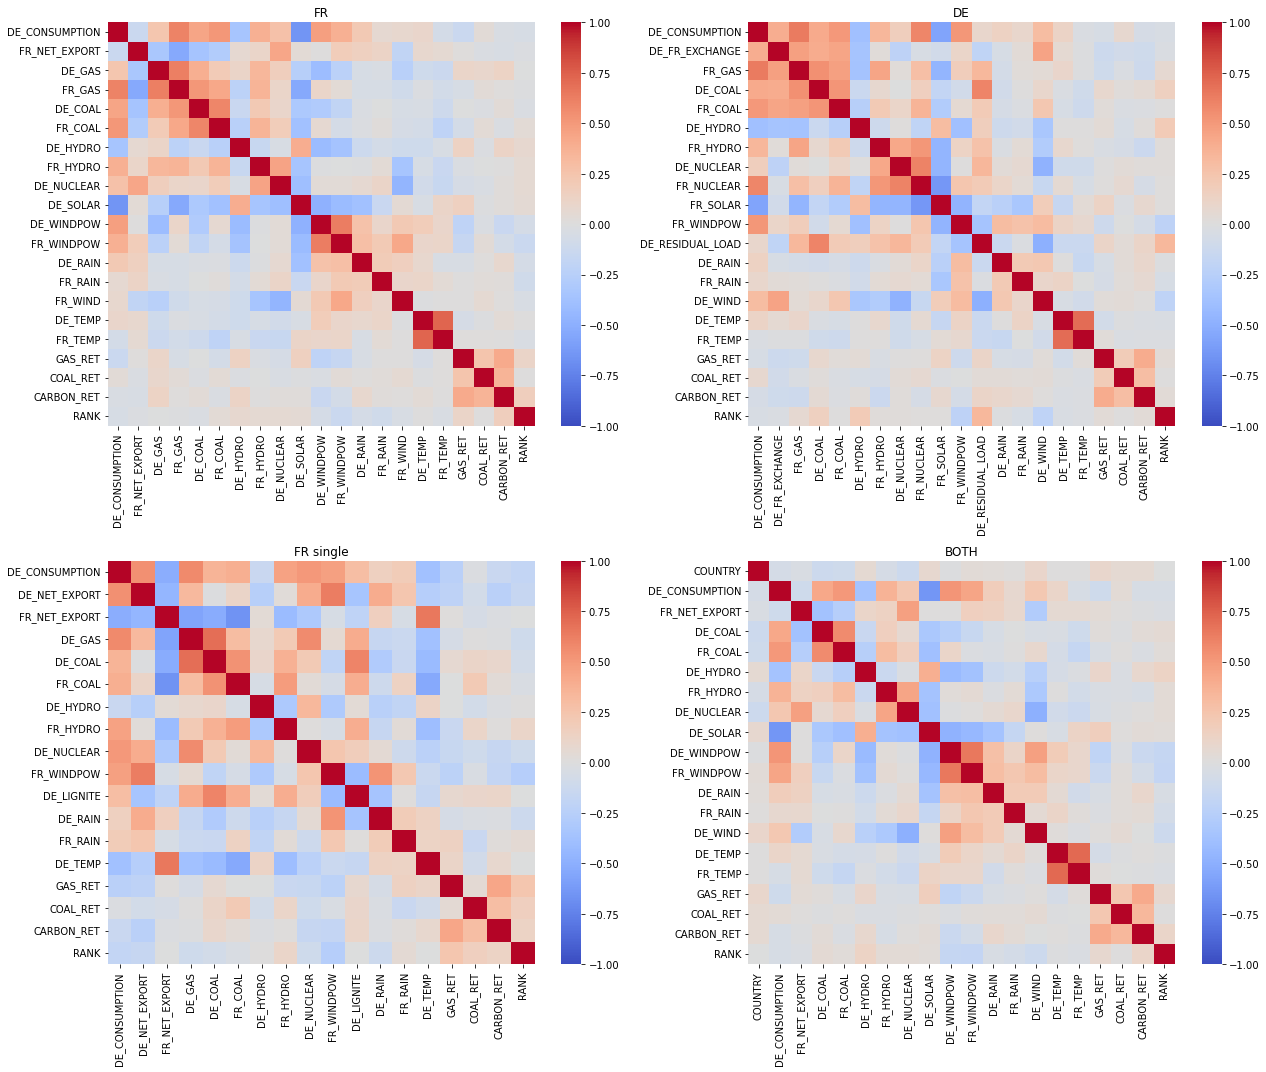

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(18,15))
# tmp = ds.dataset_fr.X_train.join(ds.dataset_fr.y_train).join(ds.dataset_fr.dtrain.TARGET)
tmp = ds_X_y_dict['train']['fr']['X'].join(ds_X_y_dict['train']['fr']['y'])
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[0][0], vmin=-1, vmax=1)
axs[0][0].set_title("FR")

tmp = ds_X_y_dict['train']['de']['X'].join(ds_X_y_dict['train']['de']['y'])
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[0][1], vmin=-1, vmax=1)
axs[0][1].set_title("DE")

tmp = ds_single_X_y_dict['train']['fr']['X'].join(ds_single_X_y_dict['train']['fr']['y'])
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[1][0], vmin=-1, vmax=1)
axs[1][0].set_title("FR single")
# display(tmp.corr(method="pearson"))

tmp = ds_X_y_dict['train']['both']['X'].join(ds_X_y_dict['train']['both']['y'])
ax = sns.heatmap(tmp.corr(method="pearson"), cmap='coolwarm', ax=axs[1][1], vmin=-1, vmax=1)
axs[1][1].set_title("BOTH")
fig.tight_layout()
plt.show()

# Voting Try

In [102]:
def _get_opt(model_name, opt_param_dict):
    opt_dict = {
        'lgbm': lgbm_optimizer(**opt_param_dict),
        'xgb': xgb_optimizer(**opt_param_dict),
        'rf': rf_optimizer(**opt_param_dict),
        'svr': svr_optimizer(**opt_param_dict),
        'ridge': ridge_optimizer(**opt_param_dict),
        'huber': huber_optimizer(**opt_param_dict),
        'knn': knn_optimizer(**opt_param_dict),
        'lasso': lasso_optimizer(**opt_param_dict),
        'elasticnet': elasticnet_optimizer(**opt_param_dict), 
    }
    return opt_dict[model_name]

def optimize_models(
    X_y_dict, 
    strat='voting_models', 
    models_list=['lgbm', 'xgb', 'rf', 'svr', 'ridge', 'huber', 'knn', 'lasso', 'elasticnet'], 
    regions_list=['fr', 'de', 'both'], 
    cv=0, 
    dump=True
):
    opt_param_dict = {
                'X_y_dict': X_y_dict,
                'cv': cv
            }
    for model_name in models_list:
        print(model_name)
        for region in regions_list:
            opt_param_dict['model_type'] = region
            opt = _get_opt(model_name=model_name, opt_param_dict=opt_param_dict)
            opt.run()
            if dump: opt.dump_best_model(f"{strat}/{model_name}_{region}.json")

In [104]:
# models_list = ['ridge', 'lasso', 'huber', 'elasticnet']
regions_list = []
optimize_models(
    ds_X_y_dict, 
    strat='voting_models_cv_5', 
    # models_list=models_list, 
    # regions_list=regions_lisst,
    cv=5,
)

lgbm
Best trial among 200 trials:
  Value: 0.20002999235868998
Best trial among 200 trials:
  Value: 0.2991392277608257
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth >

In [105]:
IGNORE_MODEL_LIST = ['svr', 'knn', 'xgb', 'lgbm', 'rf']
mbox = model_box(
    'voting_models_cv_5', 
    # ignore_models=IGNORE_MODEL_LIST,
)
model_candidates, model_scores = mbox.to_dicts()

In [106]:
# X_dict = {
#     'fr': df_same_day.loc[df_same_day.COUNTRY == 0].drop(drop_X_dict['fr'], axis=1),
#     'de': df_same_day.loc[df_same_day.COUNTRY == 1].drop(drop_X_dict['de'], axis=1),
#     'both': df_same_day.drop(drop_X_dict['both'], axis=1),
# }

X_dict = {
    'fr': fe1_train.loc[fe1_train.COUNTRY == 0].drop(drop_X_dict['fr'], axis=1),
    'de': fe1_train.loc[fe1_train.COUNTRY == 1].drop(drop_X_dict['de'], axis=1),
    'both': fe1_train.drop(drop_X_dict['both'], axis=1),
}

full_X_dict = {k: d['X'] for k, d in ds_X_y_dict['full'].items()}
test_X_dict = {k: d['X'] for k, d in ds_test_X_y_dict['full'].items()}

In [107]:
bpreds_all = []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['train'], X_dict)
    # print(key, "\n", rbp.predictors['both'].coef_)
    all_pred = rbp.aggregate_predictions(normalize=False)
    bpreds_all.append(all_pred)

bpreds_all = pd.concat(bpreds_all, axis=1)

bpreds_tra = bpreds_all.loc[ds.dataset_full.dtrain.index]
bpreds_val = bpreds_all.loc[ds.dataset_full.dvalid.index]
bpreds_ho = bpreds_all.loc[ds.dataset_full.dholdout.index]

In [108]:
for col in bpreds_tra.columns:
    # print("train", col, metric_train(bpreds_tra.loc[:, col], ds.dataset_full.y_train))
    print("valid", col, metric_train(bpreds_val.loc[:, col], ds.dataset_full.y_valid))
    # print("holdout", col, metric_train(bpreds_ho.loc[:, col], ds.dataset_full.y_holdout))

valid knn_both_pred 0.11027873204777572
valid knn_regional_pred 0.1870003973114442
valid xgb_both_pred 0.13857837943524334
valid xgb_regional_pred 0.059149847016752743
valid rf_both_pred 0.19619279745611432
valid rf_regional_pred 0.251686283133435
valid lgbm_both_pred 0.11257806279641175
valid lgbm_regional_pred 0.19809790274053704
valid huber_both_pred 0.20543537612318502
valid huber_regional_pred 0.2715290259433821
valid svr_both_pred 0.1949386222820575
valid svr_regional_pred 0.0793278968373483
valid lasso_both_pred 0.21929186962799477
valid lasso_regional_pred 0.2582990252441047
valid elasticnet_both_pred 0.20638957062954633
valid elasticnet_regional_pred 0.2875266470841406
valid ridge_both_pred 0.1997751783403492
valid ridge_regional_pred 0.2617062851003633


In [109]:
avg_pred = bpreds_all.mean(axis=1)

train_pred = avg_pred.loc[ds.dataset_full.dtrain.index]
val_pred = avg_pred.loc[ds.dataset_full.dvalid.index]

print(metric_train(train_pred, ds_X_y_dict['train']['both']['y']))
print(metric_train(val_pred, ds_X_y_dict['valid']['both']['y']))

# ho_pred = bpreds_ho.apply(lambda x: x @ weights / np.sum(weights), axis=1)
# print(metric_train(ho_pred, ds_X_y_dict['holdout']['both']['y']))

0.8316497832569097
0.25135582050856364


In [110]:
# regional_cols = [col for col in bpreds_all.columns if "regional" in col]
# avg_pred = bpreds_all[regional_cols].mean(axis=1)

# train_pred = avg_pred.loc[ds.dataset_full.dtrain.index]
# val_pred = avg_pred.loc[ds.dataset_full.dvalid.index]

# print(metric_train(train_pred, ds_X_y_dict['train']['both']['y']))
# print(metric_train(val_pred, ds_X_y_dict['valid']['both']['y']))

In [111]:
bpreds_full, bpreds_test = [], []
for key in model_candidates.keys():
    rbp = RegionalBasedPredictors(key, model_candidates[key], ds_X_y_dict['full'], test_X_dict)
    bpreds_test.append(rbp.aggregate_predictions(normalize=False))

bpreds_test = pd.concat(bpreds_test, axis=1)
# bpreds_test = bpreds_test[regional_cols]

In [106]:
# optimize_models(
#     ds_single_X_y_dict, 
#     models_list=['ridge', 'huber', 'lasso', 'elasticnet'],
#     regions_list=['fr'],
#     strat='voting_models_single_linear_cv_10', 
#     cv=10,
# )

In [119]:
# IGNORE_MODEL_LIST = ['svr']
mbox = model_box(
    'voting_models_single_linear_cv_10', 
    # ignore_models=IGNORE_MODEL_LIST,
)
model_candidates, model_scores = mbox.to_dicts()

In [120]:
bpreds_all_single = []
print(ds_single_X_y_dict['train']['fr']['X'].columns.to_list())
for key in model_candidates.keys():
    rbp = BasicPredictors(key, model_candidates[key], ds_single_X_y_dict['train'], X_single_dict)
    # print(key, "\n", rbp.predictors['fr'].coef_)
    rbp.aggregate_predictions(normalize=False)
    bpreds_all_single.append(rbp.predictions['fr'])

bpreds_all_single = pd.concat(bpreds_all_single, axis=1)
bpreds_tra_single = bpreds_all_single.loc[ds_single.dtrain.index]
bpreds_val_single = bpreds_all_single.loc[ds_single.dvalid.index]

['DE_CONSUMPTION', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RAIN', 'FR_RAIN', 'DE_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']


In [121]:
for col in bpreds_val_single.columns:
    # print("train", col, metric_train(bpreds_tra_single.loc[:, col], ds_single.y_train))
    print("valid", col, metric_train(bpreds_val_single.loc[:, col], ds_single.y_valid))

valid elasticnet_pred 0.1777125786834525
valid lasso_pred 0.023834418009175292
valid ridge_pred 0.11919342793129203
valid huber_pred 0.17939827163128136


In [122]:
avg_pred_single = bpreds_all_single.mean(axis=1)

train_pred_single = avg_pred_single.loc[ds_single.dtrain.index]
val_pred_single = avg_pred_single.loc[ds_single.dvalid.index]

print(metric_train(train_pred_single, ds_single.y_train))
print(metric_train(val_pred_single, ds_single.y_valid))

0.44476688360183514
0.10281660087485332


In [123]:
bpreds_full_single, bpreds_test_single = [], []
for key in model_candidates.keys():
    rbp = BasicPredictors(key, model_candidates[key], ds_single_X_y_dict['full'], ds_test_single_X_dict)
    bpreds_test_single.append(rbp.aggregate_predictions(normalize=False)['fr'])

bpreds_test_single = pd.concat(bpreds_test_single, axis=1)

# Submission

In [112]:
# Best # sub14
# submission = bpreds_test.mean(axis=1).rename('TARGET')
# submission_single = bpreds_test_single.mean(axis=1).rename('TARGET')
# submission.to_csv('sub18_single_fr.csv')

# submission = X_test.join(pd.concat([submission, submission_single]))['TARGET']
# submission.to_csv('sub14_remake.csv')

In [132]:
# sub = pd.concat([bpreds_test, bpreds_test_single])
# sub = sub.fillna(sub.mean(axis=0)).mean(axis=1).rename("TARGET")
# submission = X_test.join(sub)['TARGET']
# submission.to_csv('sub21_randsplit.csv')

In [127]:
sub = bpreds_test.join(bpreds_test_single)
sub = sub.mean(axis=1).rename("TARGET")
submission = X_test.join(sub)['TARGET']
submission.to_csv('sub23_sub14+linear.csv')

In [125]:
ref = pd.read_csv('sub14.csv').set_index("ID").loc[submission.index]
print(1 - metric_train(ref["TARGET"], submission))
print(1 - pearsonr(ref["TARGET"], submission)[0])

0.06032680382750788
0.05950943885262039


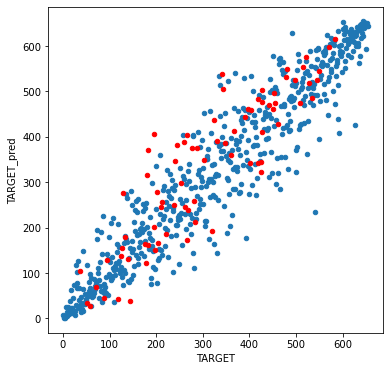

In [126]:
fig, axs = plt.subplots(1, 1, figsize=(6,6))

tmp = ref.join(submission, rsuffix="_pred")
tmp['TARGET'] = tmp['TARGET'].rank()
tmp['TARGET_pred'] = tmp['TARGET_pred'].rank()
tmp.loc[test_same_day.index].plot.scatter(x="TARGET", y="TARGET_pred", ax=axs)
tmp.loc[test_single_day.index].plot.scatter(x="TARGET", y="TARGET_pred", ax=axs, c="r")
plt.show()

# Stacking Try

In [133]:
bpreds_all

,elasticnet_both_pred,elasticnet_regional_pred,huber_both_pred,huber_regional_pred,knn_both_pred,knn_regional_pred,svr_both_pred,svr_regional_pred,lgbm_both_pred,lgbm_regional_pred,rf_both_pred,rf_regional_pred,lasso_both_pred,lasso_regional_pred,ridge_both_pred,ridge_regional_pred,xgb_both_pred,xgb_regional_pred
ID,,,,,,,,,,,,,,,,,,
1327,0.748013,1.198322,0.746038,1.177582,1.795342,2.014715,1.551487,1.690368,1.648193,1.918425,1.745941,1.522849,0.743649,0.795629,0.769390,0.913022,1.776073,1.445324
111,0.953635,0.560774,0.956257,0.559883,1.516749,0.740455,1.618578,1.146835,1.847756,0.774183,1.768866,1.080324,0.898118,0.551206,0.996758,0.594592,1.673382,0.689465
2016,0.641827,0.147133,0.632456,0.057429,0.361103,0.435728,0.943839,-0.280972,0.760681,0.698217,1.317308,0.827761,0.719403,-0.018487,0.562824,0.015996,0.719504,0.751204
800,0.847448,0.892875,0.842675,0.955525,1.903684,0.902095,1.028397,1.043860,1.438116,0.470419,1.452866,1.061769,0.873872,0.816878,0.790192,0.772665,1.134596,0.849343
2047,0.693515,0.318771,0.697892,0.332303,1.578659,1.776163,0.577543,-0.562719,1.274033,1.717519,1.199442,1.351646,0.748331,0.486762,0.703124,0.547956,1.179844,1.291271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,-0.126573,-0.027950,-0.136173,0.011189,-0.047783,0.307716,0.102625,0.176455,-0.115705,0.487243,0.030925,0.891129,0.040820,-0.023605,-0.177588,-0.089651,0.020427,0.683671
1987,-1.094634,-0.872623,-1.107079,-0.926375,-0.188619,-0.336719,-0.894324,-1.525363,-1.501132,-2.026864,-0.712689,-0.934968,-1.229476,-1.156171,-1.266502,-1.243107,-0.576648,-1.128003
771,-0.889012,-0.614687,-0.896860,-0.529935,-0.099688,0.115614,-0.820152,-0.474674,-1.308417,-0.890545,-0.942636,-0.969693,-1.075006,-0.741016,-1.039134,-0.781324,-0.508822,-0.842297


In [131]:
bpreds_all_single

,elasticnet_pred,huber_pred,svr_pred
ID,,,
1057,0.775269,0.823514,1.057608
1179,0.626640,0.635865,-0.238464
1106,0.412893,0.442706,0.425185
1170,-0.756371,-0.803469,-0.497745
936,-0.159607,-0.256054,0.088336
...,...,...,...
1094,1.184823,1.215209,1.451956
1056,-0.266725,-0.209823,0.311584
1120,-0.391997,-0.433333,-0.532519


In [134]:
ds_meta = RegionalDatasets(fe1_train, 0.4, 0.2, drop_X_dict, 'RANK')
ds_meta_X_y_dict = ds_meta.to_dict()

In [135]:
# models_list=['lgbm', 'xgb', 'rf', 'svr', 'ridge', 'huber']
# regions_list=['fr', 'de', 'both']
# optimize_models(
#     ds_meta_X_y_dict, 
#     strat='base_models_4_4_2_cv_5', 
#     models_list=models_list, 
#     regions_list=regions_list,
#     cv=5,
# )

In [136]:
IGNORE_MODEL_LIST = ['lgbm', 'xgb', 'rf']
mbox_base = model_box(
    'base_models_4_4_2_cv_5', 
    # ignore_models=IGNORE_MODEL_LIST
)
model_candidates, model_scores = mbox_base.to_dicts()

In [137]:
train_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['train'].items()}
val_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['valid'].items()}
ho_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['holdout'].items()}
full_X_dict = {k: d['X'] for k, d in ds_meta_X_y_dict['full'].items()}
test_X_dict = {k: d['X'] for k, d in ds_test_X_y_dict['full'].items()}

In [138]:
bpreds_tra, bpreds_val, bpreds_ho = [], [], []
for key in model_candidates.keys():
    rbp = StackingPredictor(key, model_candidates[key], ds_meta_X_y_dict['train'], val_X_dict)
    train_preds, val_preds = rbp.aggregate_predictions()
    bpreds_tra.append(train_preds)
    bpreds_val.append(val_preds)

    rbp.prediction_X = ho_X_dict
    _, ho_preds = rbp.aggregate_predictions()
    bpreds_ho.append(ho_preds)

bpreds_tra = pd.concat(bpreds_tra, axis=1)
bpreds_val = pd.concat(bpreds_val, axis=1)
bpreds_ho = pd.concat(bpreds_ho, axis=1)

In [139]:
print(metric_train(bpreds_tra.mean(axis=1), ds_meta_X_y_dict['train']['both']['y']))
print(metric_train(bpreds_val.mean(axis=1), ds_meta_X_y_dict['valid']['both']['y']))
print(metric_train(bpreds_ho.mean(axis=1), ds_meta_X_y_dict['holdout']['both']['y']))

0.31118642928376916
0.20574125956309386
0.3113425063410473


In [140]:
meta_X_tra = ds_meta_X_y_dict['train']['both']['X'].join(bpreds_tra)
meta_X_val = ds_meta_X_y_dict['valid']['both']['X'].join(bpreds_val)
meta_X_ho = ds_meta_X_y_dict['holdout']['both']['X'].join(bpreds_ho)

In [141]:
lv2_X_y_dict = {
    'train': {
        'both': {
            'X': meta_X_tra,
            'y': ds_meta_X_y_dict['train']['both']['y'],
        },
    },
    'valid': {
        'both': {
            'X': meta_X_val,
            'y': ds_meta_X_y_dict['valid']['both']['y'],
        },
    },
}

In [142]:
lv2 = xgb_optimizer(lv2_X_y_dict)
lv2.run()

Best trial among 200 trials:
  Value: 0.22859647351737497


In [143]:
lv2.model.fit(meta_X_tra, ds_meta_X_y_dict['train']['both']['y'])

XGBRegressor(alpha=0.014657245282989503, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5019323442722154, early_stopping_rounds=None,
             enable_categorical=False, eta=3.823673738541643e-06,
             eval_metric=None, feature_types=None, gamma=3.933349103551623e-06,
             gpu_id=None, grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, lambda=0.07737022194752848,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=16, min_child_weight=62, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [145]:
print(metric_train(lv2.model.predict(meta_X_tra), ds_meta_X_y_dict['train']['both']['y']))
print(metric_train(lv2.model.predict(meta_X_val), ds_meta_X_y_dict['valid']['both']['y']))
print(metric_train(lv2.model.predict(meta_X_ho), ds_meta_X_y_dict['holdout']['both']['y']))

0.41016583878451474
0.22859647351737497
0.30028385458639406


In [146]:
bpreds_full, bpreds_test = [], []
for key in model_candidates.keys():
    rbp = StackingPredictor(key, model_candidates[key], ds_meta_X_y_dict['full'], test_X_dict)
    full_preds, test_preds = rbp.aggregate_predictions()
    bpreds_full.append(full_preds)
    bpreds_test.append(test_preds)

bpreds_test = pd.concat(bpreds_test, axis=1)
bpreds_full = pd.concat(bpreds_full, axis=1)
meta_X_test = test_X_dict['both'].join(bpreds_test)
meta_X_full = ds_meta_X_y_dict['full']['both']['X'].join(bpreds_full)

lv2.model.fit(meta_X_full, ds_meta_X_y_dict['full']['both']['y'])

XGBRegressor(alpha=0.014657245282989503, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5019323442722154, early_stopping_rounds=None,
             enable_categorical=False, eta=3.823673738541643e-06,
             eval_metric=None, feature_types=None, gamma=3.933349103551623e-06,
             gpu_id=None, grow_policy='depthwise', importance_type=None,
             interaction_constraints=None, lambda=0.07737022194752848,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=16, min_child_weight=62, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

In [147]:
submission2 = pd.Series(lv2.model.predict(meta_X_test), index=test_X_dict['both'].index)
submission2.name = 'TARGET'
# submission2.to_csv('sub17_meta.csv')

In [148]:
print(1 - metric_train(pd.read_csv('sub11.csv')['TARGET'], submission2))
print(1 - pearsonr(pd.read_csv('sub11.csv')['TARGET'], submission2)[0])

0.1259506271163372
0.10194419068170502


In [149]:
print(1 - metric_train(submission2, submission))
print(1 - pearsonr(submission2, submission)[0])

0.05233695977997865
0.05393760424485117
